In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras.layers as layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint

2024-04-27 10:08:26.027506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 10:08:26.027634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 10:08:26.169606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
electrode_names = [
    "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
    "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
    "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
    "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
    "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
    "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
    "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
    "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
    "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
    "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
    "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
    "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
    "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
]

num_electrodes = len(electrode_names)

NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167
BATCH_SIZE = 128

In [3]:
def load_channel(cz: int, train_ratio: float = 0.9):
    train_datasets = None
    test_datasets = None
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        labels = chunk['label'].to_numpy()
        chunk = chunk[labels != -1]
        labels = labels[labels != -1]
        data = chunk.iloc[:, :-2].to_numpy().reshape(-1, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH)
        
        dataset = tf.data.Dataset.from_tensor_slices((data, labels))
        dataset = dataset.shuffle(buffer_size=len(labels))

        train_size = int(len(data) * train_ratio)
        train_data = dataset.take(train_size)
        test_data = dataset.skip(train_size)
        
        train_data = train_data.batch(BATCH_SIZE)
        test_data = test_data.batch(BATCH_SIZE)
        
        if train_datasets is None:
            train_datasets = train_data
        else:
            train_datasets = train_datasets.concatenate(train_data)
        
        if test_datasets is None:
            test_datasets = test_data
        else:
            test_datasets = test_datasets.concatenate(test_data)
    
    return train_datasets, test_datasets

train, test = load_channel(1000)


61it [10:47, 10.62s/it]


In [4]:
input_data = layers.Input((NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
x = layers.Rescaling(1/30000)(input_data)
x = layers.Conv1D(64, 16, activation='leaky_relu', data_format='channels_first', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='leaky_relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 167)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 167)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 167)        │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 167)        │           668 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,736,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,870,758 (10.95 MB)

 Trainable params: 2,870,424 (10.95 MB)

 Non-trainable params: 334 (1.30 KB)

In [5]:
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras')
history = model.fit(train, validation_data=test, epochs=250, verbose=2, callbacks=[checkpoint], shuffle=True)

Epoch 1/250


I0000 00:00:1714213175.679287      65 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714213175.697433      65 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714213191.074386      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


480/480 - 28s - 57ms/step - accuracy: 0.0993 - loss: 3.5802 - val_accuracy: 0.1001 - val_loss: 2.7219
Epoch 2/250
480/480 - 6s - 12ms/step - accuracy: 0.1042 - loss: 2.6090 - val_accuracy: 0.1025 - val_loss: 2.4192
Epoch 3/250
480/480 - 6s - 12ms/step - accuracy: 0.1078 - loss: 2.4136 - val_accuracy: 0.1120 - val_loss: 2.3583
Epoch 4/250
480/480 - 6s - 12ms/step - accuracy: 0.1120 - loss: 2.3523 - val_accuracy: 0.1203 - val_loss: 2.3218
Epoch 5/250
480/480 - 6s - 12ms/step - accuracy: 0.1122 - loss: 2.3282 - val_accuracy: 0.1110 - val_loss: 2.3263
Epoch 6/250
480/480 - 6s - 12ms/step - accuracy: 0.1127 - loss: 2.3202 - val_accuracy: 0.1080 - val_loss: 2.3208
Epoch 7/250
480/480 - 6s - 12ms/step - accuracy: 0.1108 - loss: 2.3129 - val_accuracy: 0.1143 - val_loss: 2.3169
Epoch 8/250
480/480 - 6s - 12ms/step - accuracy: 0.1134 - loss: 2.3102 - val_accuracy: 0.1185 - val_loss: 2.3151
Epoch 9/250
480/480 - 6s - 12ms/step - accuracy: 0.1129 - loss: 2.3079 - val_accuracy: 0.1111 - val_loss: 2

Text(0.5, 1.0, 'Loss during Training')

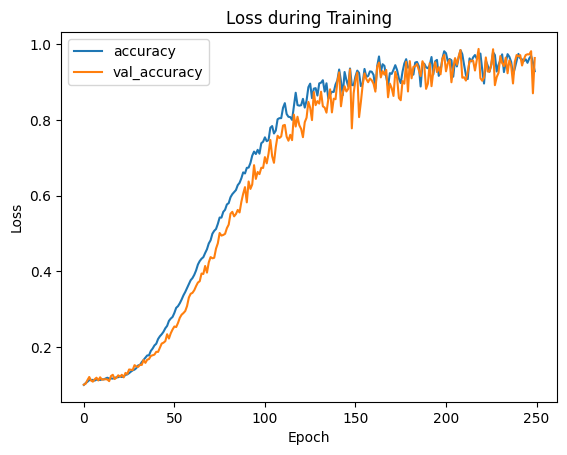

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")